# 포탈 04  - 재무제표 크롤링

<img src="http://i.imgur.com/grQHNKG.jpg">

#### 2017-2019 [FinanceData.KR](FinanceData.KR)

# 네이버 파이낸스 크롤링

파이썬으로 데이터 크롤링 할 때 requests 와 BeautifulSoup 를 많이 사용한다. 표(table)로 정리된 데이터의 경우 pandas의 read_html()을 활용하면 간편하게 크롤링 할 수 있는 경우가 많다. 이 글에서는 네이버 파이낸스의 페이지 구조를 파악하고, 재무제표 정보를 pandas DataFrame으로 읽어 처리하는 방법을 살펴본다. <!-- TEASER_END --> 종목별 예제로는 삼성전자(005930)을 사용한다.

# 페이지 구성

[네이버 파이낸스](http://finance.naver.com)에서 005930(삼성전자) 종목의 재무제표 정보 페이지의 구성을 단계별로 살펴보자. (이 구성은 크롬 혹은 파이어폭스의 개발자 도구로 살펴볼 수 있다) 


## 1) 종목정보
아래 링크에서 종목정보를 볼 수 있다.
* http://finance.naver.com/item/coinfo.nhn?code=005930
* 페이지 아래 부분 "Financial Summary" 영역에 재무제표가 있는데 iframe으로 구성되어 있다.

## 2) Financial Summary 영역
iframe 의 src 링크는 아래와 같이 구성되어 있다.
* http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930&target=finsum_more
* 실제 내용은 JavaScript가 HTML 문서를 가져와 붙이도록 되어 있다

## 3) 재무제표
JavaScript가 요청하는 URL은 아래와 같다. <br>
http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?cmp_cd=005930&fin_typ=0&freq_typ=A&encparam=RTdld3pVNlhnSEEvNncvSVVBTzZJQT09&id=TDdCYnFkT0

(2018년 9월 초, 사이트 변경. encparam, id 가 추가됨)

네이버 파이낸스에서 재무제표 데이터를 크롤링 하기 위한 URL

http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?cmp_cd=005930&fin_typ=0&freq_typ=Y&encparam=RTdld3pVNlhnSEEvNncvSVVBTzZJQT09&id=TDdCYnFkT0


URL을 구성하는 파라미터의 의미는 다음과 같다.

인자 | 의미 | 값
-- | -- | --
cmp_cd |  종목코드 | 005930 (종목코드)
fin_typ | 재무제표 타입 | 0: 주재무제표, 1: GAAP개별, 2: GAAP연결, 3: IFRS별도, 4:IFRS연결
freq_typ | 기간 | Y:년, Q:분기
encparam | 암호화된 정보 | 
id | 암호화된 정보 | 종목코드로 추정

# encparam, id 를 추출

재무 데이터 URL을 생성하는데 encparam, id가 사용된다.  

http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930

위 페이지 포함된 코드에서 encparam 과 id 를 추출한다.

```javascript
$.ajax({
	url     : "ajax/cF1001.aspx",
	async  : false,
	type    : 'get',
	dataType: 'html',
	data: {
	cmp_cd    : '068270'
	, fin_typ : _fin_typ
	, freq_typ: _freq_typ
	, extY: extY
	, extQ: extQ
	, encparam: 'NG1FZUtSR092Y2E4OHZ6Q09Wajcvdz09'
	, id: 'aFVlanREZS' ? 'aFVlanREZS' : ''
	},
```


In [17]:
import re
import requests

url_tmpl = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=%s'
url = url_tmpl % ('005930' )

html_text = requests.get(url).text

encparam = re.findall ("encparam: '(.*?)'", html_text)[0]
encid = re.findall ("id: '(.*?)'", html_text)[0]

encparam, encid 

('ZVp6ZXZNOGNMME9rSE5ad3RGZ01rZz09', 'ZlEwemUxRm')

# pandas.read_html 활용한 크롤링

pandas.read_html(url)은 HTML 페이지에 포함된 TABLE들을 DataFrame 의 리스트로 반환한다. 우리가 사용하는 재무제표 페이지는 2개의 TABLE을 포함하고 있으며, 두첫번째 [1] 요소가 바로 재무제표 정보를 담은 DataFrame이 된다.

In [18]:
import pandas as pd
from io import StringIO

#  재무데이터 표 추출
url_tmpl = 'http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?' \
                'cmp_cd=%s&fin_typ=%s&freq_typ=%s&encparam=%s&id=%s'

url = url_tmpl % ('005930', '4', 'Y', encparam, encid) # 삼성전자, 4(IFRS 연결), Y:년 단위

header = {
    'Referer': 'https://companyinfo.stock.naver.com/v1/company/c1010001.aspx',
}

html_text = requests.get(url, headers=header).text
dfs = pd.read_html(StringIO(html_text))
df = dfs[1]

print(url)
df.head(10) # 10개 항목만 표시(실제 32개 항목)

http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?cmp_cd=005930&fin_typ=4&freq_typ=Y&encparam=ZVp6ZXZNOGNMME9rSE5ad3RGZ01rZz09&id=ZlEwemUxRm


주요재무정보                연간                                      \
       주요재무정보 2014/12  (IFRS연결) 2015/12  (IFRS연결) 2016/12  (IFRS연결)   
0         매출액         2062060.0         2006535.0         2018667.0   
1        영업이익          250251.0          264134.0          292407.0   
2  영업이익(발표기준)          250251.0          264134.0          292407.0   
3    세전계속사업이익          278750.0          259610.0          307137.0   
4       당기순이익          233944.0          190601.0          227261.0   
5   당기순이익(지배)          230825.0          186946.0          224157.0   
6  당기순이익(비지배)            3119.0            3655.0            3104.0   
7        자산총계         2304230.0         2421795.0         2621743.0   
8        부채총계          623348.0          631197.0          692113.0   
9        자본총계         1680882.0         1790598.0         1929630.0   

                                                            \
  2017/12  (IFRS연결) 2018/12  (IFRS연결) 2019/12(E)  (IFRS연결)   
0         2395754.0         2437714.0            2233940.0   
1          536450.0          588867.0             304906.0   
2          536450.0          588867.0                  NaN   
3          561960.0          611600.0             329221.0   
4          421867.0          443449.0             240090.0   
5          413446.0          438909.0             236785.0   
6            8422.0               NaN                  NaN   
7         3017521.0         3393572.0            3551531.0   
8          872607.0          916041.0             918092.0   
9         2144914.0         2477532.0            2631922.0   

                                             
  2020/12(E)  (IFRS연결) 2021/12(E)  (IFRS연결)  
0            2383554.0            2512292.0  
1             390918.0             477561.0  
2                  NaN                  NaN  
3             420066.0             508711.0  
4             307362.0             370855.0  
5             302233.0             366200.0  
6                  NaN                  NaN  
7            3806909.0            4106408.0  
8             964756.0             966109.0  
9            2832688.0            3076896.0

단, 5줄의 코드로 삼성전자 재무제표를 크롤링 했다! (의외로 이렇게 크롤링 할 수 있는 정보들이 꽤 많다)

# 문제점과 해결방안
표시된 DataFrame을 자세히 살펴보면 아래와 같은 문제점들이 있다. (대부분 네이버 파이낸스 페이지의 HTML TABLE 표현의 문제다)

### 문제점
1. '연간'이른 컬럼명이 추가되었고, 컬럼 이름이 한 컬럼씩 오른쪽으로 밀렸다. 
2. 마지막 컬럼의 값이 NaN 값 (컬럼 이름이 밀려서 발생)
3. 날짜에 "(IFRS연결)"와 같이 불필요한 문자열 포함하고 있다.
4. 시계열 데이터로 처리하려면, '주요재무정보'가 컬럼이 되고 날짜가 행(row)가 되는 것이 편리하다.

### 각 문제에 대한 해결방안
1. 컬럼명 '연간' 삭제
2. 컬럼 문자열에서 날짜(년, 월)만 추출 (정규식 사용)
3. 마지막 컬럼 삭제
4. 컬럼과 로우를 전환 (df.T) 한다 (transpose 우리말로 전치행렬 이라고 한다)

# 1. 컬럼 정리
* '주요재무정보'를 처음에
* 년도 부분을 목록으로 만들어 추가

In [19]:
# 리스트로 전환
cols = list(df.columns)
cols

[('주요재무정보', '주요재무정보'),
 ('연간', '2014/12  (IFRS연결)'),
 ('연간', '2015/12  (IFRS연결)'),
 ('연간', '2016/12  (IFRS연결)'),
 ('연간', '2017/12  (IFRS연결)'),
 ('연간', '2018/12  (IFRS연결)'),
 ('연간', '2019/12(E)  (IFRS연결)'),
 ('연간', '2020/12(E)  (IFRS연결)'),
 ('연간', '2021/12(E)  (IFRS연결)')]

In [20]:
df.columns = [c[1] for c in cols]
df.columns

Index(['주요재무정보', '2014/12  (IFRS연결)', '2015/12  (IFRS연결)', '2016/12  (IFRS연결)',
       '2017/12  (IFRS연결)', '2018/12  (IFRS연결)', '2019/12(E)  (IFRS연결)',
       '2020/12(E)  (IFRS연결)', '2021/12(E)  (IFRS연결)'],
      dtype='object')

In [21]:
df = df.set_index('주요재무정보')
df.head(10) # 10개 항목만 표시(실제 32개 항목)

,2014/12 (IFRS연결),2015/12 (IFRS연결),2016/12 (IFRS연결),2017/12 (IFRS연결),2018/12 (IFRS연결),2019/12(E) (IFRS연결),2020/12(E) (IFRS연결),2021/12(E) (IFRS연결)
주요재무정보,,,,,,,,
매출액,2062060.0,2006535.0,2018667.0,2395754.0,2437714.0,2233940.0,2383554.0,2512292.0
영업이익,250251.0,264134.0,292407.0,536450.0,588867.0,304906.0,390918.0,477561.0
영업이익(발표기준),250251.0,264134.0,292407.0,536450.0,588867.0,NaN,NaN,NaN
세전계속사업이익,278750.0,259610.0,307137.0,561960.0,611600.0,329221.0,420066.0,508711.0
당기순이익,233944.0,190601.0,227261.0,421867.0,443449.0,240090.0,307362.0,370855.0
당기순이익(지배),230825.0,186946.0,224157.0,413446.0,438909.0,236785.0,302233.0,366200.0
당기순이익(비지배),3119.0,3655.0,3104.0,8422.0,NaN,NaN,NaN,NaN
자산총계,2304230.0,2421795.0,2621743.0,3017521.0,3393572.0,3551531.0,3806909.0,4106408.0
부채총계,623348.0,631197.0,692113.0,872607.0,916041.0,918092.0,964756.0,966109.0


# 2. 컬럼 문자열에서 날짜(년, 월) 추출

컬럼은 날짜 데이터이다. 그러나 불필요한 문자('\n', '\t', '(IFRS연결)' 등)이 포함되어 있다. 추후 Datetime으로 활용하기 위해 날짜에 해당하는 문자열만 추출해 보자.

```
'\n\t\t\t\t\t\t\t\t\t2011/12\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t(IFRS연결)\n\t\t\t\t\t\t\t\t' 
```


위 문자열에서 '2011/12' 문자열만 추출하기 위해 아래와 같은 코드를 사용할 수 도 있겠지만,

```python
    date_str = r['date'].replace('\t', '').replace('\n', '')
    date_str = date_str.replace('(E)', '')
    date_str = date_str.replace('/', '-')
    date_str = date_str.replace(')', '')
```

정규식(regular expression)을 사용하는 것이 훨씬 깔끔하고 적응력이 좋아진다. 
날짜 추출에 필요한 정규식을 만들어 보자.

In [22]:
import re
from datetime import datetime

s =  '\n\t\t\t\t\t\t\t\t\t2011/12\n\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t(IFRS연결)\n\t\t\t\t\t\t\t\t'

date_str = ''
r = re.search("\d{4}/\d{2}", s)
if r:
    date_str = r.group()

date_str

'2011/12'

날짜를 추출하는 내용을 함수로 만들어 컬럼 이름에 적용한다.

In [0]:
import re
from datetime import datetime

def get_date_str(s):
    date_str = ''
    r = re.search("\d{4}/\d{2}", s)
    if r:
        date_str = r.group()
        date_str = date_str.replace('/', '-')

    return date_str

이 함수를 사용하여 아래와 같이 모든 컬럼에서 날짜에 해당하는 문자열을 추출할 수 있다.

In [24]:
df.columns = [get_date_str(x) for x in df.columns]
df.columns

Index(['2014-12', '2015-12', '2016-12', '2017-12', '2018-12', '2019-12',
       '2020-12', '2021-12'],
      dtype='object')

# 정리: 함수로 만들기

재사용하기 위해 앞선 내용을 정리하여 함수로 만든다.

In [0]:
import re
from datetime import datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO

'''
get_date_str(s) - 문자열 s 에서 "YYYY/MM" 문자열 추출
'''
def get_date_str(s):
    date_str = ''
    r = re.search("\d{4}/\d{2}", s)
    if r:
        date_str = r.group()
        date_str = date_str.replace('/', '-')

    return date_str

'''
* code: 종목코드
* fin_type(종류): 0=주재무제표(기본), 1=GAAP개별, 2=GAAP연결, 3=IFRS별도, 4=FRS연결
* freq_type(기간): Y=년(기본), Q=분기
'''
def get_finstate_naver(code, fin_type='0', freq_type='Y'):
    # encparam, encid  추출
    url_tmpl = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=%s'
    url = url_tmpl % ( code)

    html_text = requests.get(url).text
    if '기업재무정보 접속장애' in html_text:
      return None

    encparam = re.findall ("encparam: '(.*?)'", html_text)[0]
    encid = re.findall ("id: '(.*?)'", html_text)[0]

    #  재무데이터 표 추출
    url_tmpl = 'http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?' \
                    'cmp_cd=%s&fin_typ=%s&freq_typ=%s&encparam=%s&id=%s'

    url = url_tmpl % (code, fin_type, freq_type, encparam, encid)

    header = {
        'Referer': 'https://companyinfo.stock.naver.com/v1/company/c1010001.aspx',
    }

    html_text = requests.get(url, headers=header).text
    dfs = pd.read_html(StringIO(html_text))
    df = dfs[1]
    if df.iloc[0,0].find('해당 데이터가 존재하지 않습니다') >= 0:
        return None
    
    cols = list(df.columns)
    df.columns = [c[1] for c in cols]
    df.set_index('주요재무정보', inplace=True)
    df.columns = [get_date_str(x) for x in df.columns]
    
    return df

In [34]:
# 삼성전자 (년간, IFRS연결)
df = get_finstate_naver('005930', fin_type='3', freq_type='Q')
df

,2017-12,2018-03,2018-06,2018-09,2018-12,2019-03,2019-06,2019-09
주요재무정보,,,,,,,,
매출액,4.213140e+05,4.260700e+05,4.131470e+05,4.764530e+05,3.881480e+05,NaN,NaN,NaN
영업이익,1.125950e+05,1.120090e+05,1.104960e+05,1.391270e+05,7.536200e+04,NaN,NaN,NaN
영업이익(발표기준),1.125950e+05,1.120090e+05,1.104960e+05,1.391270e+05,7.536200e+04,NaN,NaN,NaN
세전계속사업이익,1.226070e+05,1.156900e+05,1.109460e+05,1.388720e+05,7.848100e+04,NaN,NaN,NaN
당기순이익,1.000600e+05,8.452500e+04,8.078000e+04,1.021150e+05,6.073100e+04,NaN,NaN,NaN
당기순이익(지배),1.000600e+05,8.452500e+04,8.078000e+04,1.021150e+05,6.073100e+04,NaN,NaN,NaN
당기순이익(비지배),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
자산총계,1.982414e+06,2.052062e+06,2.039701e+06,2.177994e+06,2.190214e+06,NaN,NaN,NaN
부채총계,4.667160e+05,4.901080e+05,4.213050e+05,4.814060e+05,4.603320e+05,NaN,NaN,NaN


In [27]:
df = get_finstate_naver('035720', fin_type='3', freq_type='Y')
df

,2014-12,2015-12,2016-12,2017-12,2018-12,2019-12,2020-12,2021-12
주요재무정보,,,,,,,,
매출액,4878.00,8621.00,8612.00,9787.00,11739.00,NaN,NaN,NaN
영업이익,1825.00,1206.00,710.00,976.00,1224.00,NaN,NaN,NaN
영업이익(발표기준),1825.00,1206.00,710.00,976.00,1224.00,NaN,NaN,NaN
세전계속사업이익,1792.00,1012.00,526.00,2474.00,1827.00,NaN,NaN,NaN
당기순이익,1603.00,729.00,382.00,2176.00,902.00,NaN,NaN,NaN
당기순이익(지배),1603.00,729.00,382.00,2176.00,902.00,NaN,NaN,NaN
당기순이익(비지배),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
자산총계,27558.00,31171.00,48293.00,49569.00,62028.00,NaN,NaN,NaN
부채총계,2950.00,5422.00,14541.00,13992.00,14515.00,NaN,NaN,NaN


# 활용 예

In [28]:
#df = get_finstate_naver('035720') # 셀트리온 068270 
df = get_finstate_naver('035720') # 카카오 035720
#df = get_finstate_naver('035720') # CJ E&M 130960
#df = get_finstate_naver('035720') # 메디톡스 086900

df

,2014-12,2015-12,2016-12,2017-12,2018-12,2019-12,2020-12,2021-12
주요재무정보,,,,,,,,
매출액,4989.00,9322.00,14642.00,19723.00,24170.00,28698.00,33222.00,38257.00
영업이익,1764.00,886.00,1161.00,1654.00,729.00,1461.00,2470.00,3490.00
영업이익(발표기준),1764.00,886.00,1161.00,1654.00,729.00,NaN,NaN,NaN
세전계속사업이익,1688.00,1095.00,1003.00,1533.00,1307.00,1748.00,2857.00,3865.00
당기순이익,1498.00,788.00,655.00,1251.00,159.00,1251.00,2051.00,2836.00
당기순이익(지배),1501.00,757.00,577.00,1086.00,479.00,1177.00,1905.00,2650.00
당기순이익(비지배),-3.00,31.00,78.00,165.00,NaN,NaN,NaN,NaN
자산총계,27680.00,31885.00,54841.00,63494.00,79595.00,77685.00,81430.00,87572.00
부채총계,3048.00,6030.00,17812.00,18865.00,23324.00,22774.00,24575.00,26202.00


# 컬럼과 로우 전환
DataFrame.T (transpose, 전치행열)를 사용하면 행, 열이 전환된 DataFrame을 구할 수 있다. 시간을 인덱스로하여 시계열 데이터로 만드는 것이 데이터 분석과 시각화에 유리하다.

In [29]:
dft = df.T

# 첫번째 컬럼 이름을 data로 변경
dft.rename(columns={'주요재무정보':'date'}, inplace=True)

# 인덱스를 날짜형식(datetime)으로 변환
dft.index = pd.to_datetime(dft.index)

# 필요한 컬럼만 출력해 본다
dft[['매출액', '당기순이익', '부채총계', 'PER(배)' , 'PBR(배)', '현금배당수익률']]

주요재무정보,매출액,당기순이익,부채총계,PER(배),PBR(배),현금배당수익률
2014-12-01,4989.0,1498.0,3048.0,20.21,2.92,0.14
2015-12-01,9322.0,788.0,6030.0,91.24,2.73,0.14
2016-12-01,14642.0,655.0,17812.0,88.15,1.52,0.19
2017-12-01,19723.0,1251.0,18865.0,85.50,2.31,0.11
2018-12-01,24170.0,159.0,23324.0,168.01,1.59,0.12
2019-12-01,28698.0,1251.0,22774.0,81.51,1.82,0.13
2020-12-01,33222.0,2051.0,24575.0,50.34,1.76,0.14
2021-12-01,38257.0,2836.0,26202.0,36.19,1.61,0.17


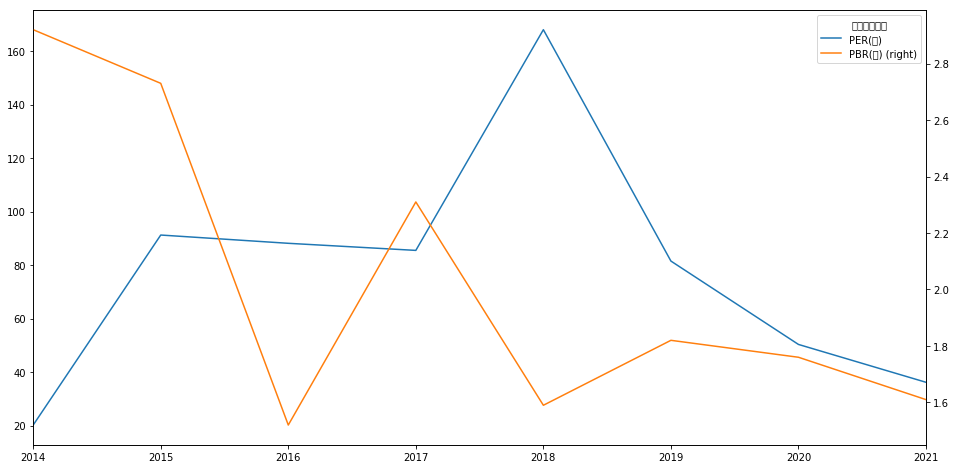

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

dft[['PER(배)', 'PBR(배)']].plot(figsize=(16,8), secondary_y='PBR(배)')

In [31]:
# 컬럼 확인

dft.columns

Index(['매출액', '영업이익', '영업이익(발표기준)', '세전계속사업이익', '당기순이익', '당기순이익(지배)',
       '당기순이익(비지배)', '자산총계', '부채총계', '자본총계', '자본총계(지배)', '자본총계(비지배)', '자본금',
       '영업활동현금흐름', '투자활동현금흐름', '재무활동현금흐름', 'CAPEX', 'FCF', '이자발생부채', '영업이익률',
       '순이익률', 'ROE(%)', 'ROA(%)', '부채비율', '자본유보율', 'EPS(원)', 'PER(배)',
       'BPS(원)', 'PBR(배)', '현금DPS(원)', '현금배당수익률', '현금배당성향(%)', '발행주식수(보통주)'],
      dtype='object', name='주요재무정보')

In [32]:
# 인덱스 확인

dft.index

DatetimeIndex(['2014-12-01', '2015-12-01', '2016-12-01', '2017-12-01',
               '2018-12-01', '2019-12-01', '2020-12-01', '2021-12-01'],
              dtype='datetime64[ns]', freq=None)

# 요약

* 파이썬 데이터 크롤링, requests를 주로 사용하지만 TABLE에 pandas.read_html()를 사용하여 간결하게 처리할 수 있다.
* 정규식을 사용하여 문자열을 추출하는 것이 유연성과 적응성이 뛰어나다. (replace 같은 문자열 처리함수를 사용하는 것 보다.
* pandas.DataFrame의 컬럼, 인덱스 조작을 통해 DataFrame을 적절하게 가공할 수 있다.
* DataFrame으로 만들어지면 파일(csv, excel, RDB)등으로 변환하기 좋고, 시각화 하기도 용이하다.

#### 2017-2019 [FinanceData.KR](FinanceData.KR)